#**Pokemon Q-Learning!!**

This is a Q-learning implementation for the MDP described by the last question on the DS340 Final. The question described a simplified version of Pokemon with roughly the following rules:



1.   The agent and the opponent each start with 20 hit points (hp). At no point during the game can they exceed this amount (see healing).
2.   At each turn, the agent can decide between 1 of 3 moves:

  *   Attack - Deal between 1 and 5 hp of damage to opponent with uniform probability
  * Heal - Heal between 1 and 5 of the agent's own hp with uniform probability
  * Mesmerize - Mesmerize the opponent with a 20% chance. If successful, the opponent cannot act again until they are attacked by the agent.
3.   At each turn, the opponent will make a move according to the following (hopefully close to optimal) policy:
  * If own hp $\gt 5$ OR agent's hp $\le 3$, then Attack. Else, Heal.
  * Healing and Attacking have the same probabilities as given above. The opponent is not able to mesmerize the agent.



*There is a lot of randomness in the game, so any of these probabilites might be changed later to encourage the agent to be more strategic.

We could just solve this MDP using the Bellman equation, but the idea of having an agent stumble around and learn the rules of the game is more fun, so we'll implement Q-learning. Each state of the game will track (agent_hp, opponent_hp, opponent_mesmerized).






In [2]:
#install dependencies for game UI (restart the runtime)
%%capture
!pip install panel param bokeh jupyter_bokeh -U

In [1]:
#Setting parameters

#Q-LEARNING PARAMETERS
DISCOUNT_FACTOR = 0.9
EXPLORE_PROB = 0.2  #for epsilon-greedy
LEARNING_RATE = 0.01
WIN_REWARD = 250.0
LOSS_REWARD = -150.0
ITERATIONS = 20000

#GAME PARAMETERS
MAX_HP=20
MAX_DAMAGE=5
MAX_HEAL=5
MESMERIZE_PROB=0.2
AGENT_ACTIONS = ["attack", "heal", "mesmerize"]
OPPONENT_ACTIONS = ["attack", "heal"]

In [2]:
#Setting up useful classes

class State:
  """
  - A state of the Pokemon game tracking (agent_hp, opponent_hp, opponent_mesmerized)
  - Also track if a state is a terminal state -> either player has zero hp
  """

  def __init__(self, agent_hp, opponent_hp, opponent_mesmerized):
    self.agent_hp = agent_hp
    self.opponent_hp = opponent_hp
    self.opponent_mesmerized = opponent_mesmerized


  def __eq__(self, other):
    return self.agent_hp == other.agent_hp and self.opponent_hp == other.opponent_hp \
    and self.opponent_mesmerized == other.opponent_mesmerized

  #used to hash a state into Q-table
  #State objects should be treated as immutable, this is fine
  #satisfies: x==y -> hash(x) = hash(y)
  def __hash__(self):
    return hash((self.agent_hp, self.opponent_hp, self.opponent_mesmerized))


  def __str__(self):
    return f"Agent HP: {self.agent_hp}, Opponent HP: {self.opponent_hp}, Mesmerized: {self.opponent_mesmerized}"

  #returns True if the agent has won the game
  def is_win(self):
    return self.agent_hp > 0 and self.opponent_hp == 0

  #returns True if the agent has lost the game
  def is_loss(self):
    return self.agent_hp == 0 and self.opponent_hp > 0

  def get_fields(self):
    return self.agent_hp, self.opponent_hp, self.opponent_mesmerized



class QTable:
  """
  - A table of Q-values for each state and action pair
  - The table will be a dictionary, keys are (agent_hp, opponent_hp, opponent_mesmerized)
  - Values are a list of Q-values, the index in the list corresponds to the action's index in AGENT_ACTIONS
  """

  def __init__(self):
    self.table = {}


  #adds a State to the table if it does not already exist
  #if it is a terminal state, adds appropriate Q-values
  def add(self, state):
    if state not in self.table:
      if state.is_win():
        self.table[state] = [WIN_REWARD for _ in range(len(AGENT_ACTIONS))]
      elif state.is_loss():
        self.table[state] = [LOSS_REWARD for _ in range(len(AGENT_ACTIONS))]
      else:
        self.table[state] = [0.0 for _ in range(len(AGENT_ACTIONS))]


  def num_states_seen(self):
    return len(self.table)


In [3]:
#Q-learning functions

import random

def get_opponent_move(agent_hp, opponent_hp):
  """
  Returns opponent move. This policy is handcrafted and seems to describe
  how a sensible person would play, but it is deterministic and could be improved
  with a smarter algorithm.
  """

  if opponent_hp > 5 or agent_hp <= 3:
    return "attack"
  else:
    return "heal"



def get_next_eg(state, q_table):
  """
  Returns the next state and agent's action after one turn of the game (a single
  agent move followed by a single opponent move). Using an epsilon-greedy
  exploration strategy.

  Should not be called with a terminal state.
  """

  #store fields
  agent_hp, opponent_hp, opponent_mesmerized = state.get_fields()

  #choose agent_action using epsilon greedy, also random move if state is unexplored
  if random.random() < EXPLORE_PROB or q_table.table[state] == [0,0,0]:
    agent_action = random.choice(AGENT_ACTIONS)
  else:
    agent_action = AGENT_ACTIONS[q_table.table[state].index(max(q_table.table[state]))]

  #update new values after agent's move
  if agent_action == "attack":
    opponent_hp -= random.randint(1, MAX_DAMAGE)
    opponent_mesmerized = False
    opponent_hp = max(0, opponent_hp)

  elif agent_action == "heal":
    agent_hp += random.randint(1, MAX_HEAL)
    agent_hp = min(MAX_HP, agent_hp)

  else:
    #mesmerize. if the opponent is already mesmerized this will do nothing
    if random.random() < MESMERIZE_PROB:
      opponent_mesmerized = True

  #if the opponent has 0 hp or is mesmerized after agent move then
  #we don't consider the opponent's move
  if opponent_hp == 0 or opponent_mesmerized:
    return State(agent_hp, opponent_hp, opponent_mesmerized), agent_action

  #update new values after opponent's move
  opponent_action = get_opponent_move(agent_hp, opponent_hp)
  if opponent_action == "attack":
    agent_hp -= random.randint(1, MAX_DAMAGE)
    agent_hp = max(0, agent_hp)

  else:
    #opponent chose to heal
    opponent_hp += random.randint(1, MAX_HEAL)
    opponent_hp = min(MAX_HP, opponent_hp)

  return State(agent_hp, opponent_hp, opponent_mesmerized), agent_action


def update_q(current_state, next_state, agent_action, q_table):
  """
  Updates the q-value of a state action pair after a move is made.
  """

  move_num = AGENT_ACTIONS.index(agent_action) #index of q-value to update

  old_q = q_table.table[current_state][move_num]
  best_new_q = max(q_table.table[next_state])

  #no reward function R(s,a,s')
  new_q = old_q + LEARNING_RATE * (0 + DISCOUNT_FACTOR * best_new_q - old_q)

  #update the q value for the current state, action pair
  q_table.table[current_state][move_num] = new_q



def q_solve(initial_state, iterations):
  """
  Each iteration starts the agent from the initial state of the game where both players have full
  hp and the opponent is not mesmerized. There should be enough randomness that starting
  the agent from the same state at each iteration will not stall learning.

  Each iteration will run until the agent has either won or lost and q-values
  will be updated as the agent explores the state space. There is no reward
  function for the agent, but the q-values for the win and loss states will be
  the win and loss rewards.

  Returns the Q-table generated after all iterations. This can be used to
  determine the policy on the fly.
  """
  print(f"Running for {iterations} iterations...")
  #print win percentage every 1000 iterations
  print_every = 1000

  #initialize Q table
  q_table = QTable()
  q_table.add(initial_state)

  num_wins = 0
  total = 0

  for i in range(iterations):
    current_state = initial_state

    while not current_state.is_win() and not current_state.is_loss():

      #Run agent move and opponent move and get the resulting state (uses epsilon greedy)
      next_state, agent_action = get_next_eg(current_state, q_table)

      #add the state - only gets added if unseen. If it is terminal the q-values are set
      #to appropriate rewards and we can update q-values and terminate the run
      q_table.add(next_state)

      #Update Q-values
      update_q(current_state, next_state, agent_action, q_table)

      #update current state
      current_state = next_state

    if current_state.is_win():
      num_wins += 1

    total += 1


    if (i+1) % print_every == 0:
     print(f"Win Rate at Iteration {i+1}: {num_wins/total}")

  return q_table

With everything set up, we can train the agent:

In [4]:
#Train the agent with the default parameters above

initial_state = State(20, 20, False)
q_table = q_solve(initial_state, ITERATIONS)

Running for 20000 iterations...
Win Rate at Iteration 1000: 0.242
Win Rate at Iteration 2000: 0.304
Win Rate at Iteration 3000: 0.33266666666666667
Win Rate at Iteration 4000: 0.35225
Win Rate at Iteration 5000: 0.366
Win Rate at Iteration 6000: 0.37533333333333335
Win Rate at Iteration 7000: 0.38471428571428573
Win Rate at Iteration 8000: 0.391375
Win Rate at Iteration 9000: 0.3953333333333333
Win Rate at Iteration 10000: 0.4003
Win Rate at Iteration 11000: 0.402
Win Rate at Iteration 12000: 0.4058333333333333
Win Rate at Iteration 13000: 0.4065384615384615
Win Rate at Iteration 14000: 0.4074285714285714
Win Rate at Iteration 15000: 0.40813333333333335
Win Rate at Iteration 16000: 0.4103125
Win Rate at Iteration 17000: 0.4122941176470588
Win Rate at Iteration 18000: 0.4147777777777778
Win Rate at Iteration 19000: 0.41568421052631577
Win Rate at Iteration 20000: 0.41555


It looks like everything is working as expected. It's interesting to see how training is affected when we play with the parameters, especially with the mesmerize probability:

In [5]:
#Increasing mesmerize probability: 0.2 -> 0.8
MESMERIZE_PROB=0.8

In [6]:
#Train the agent with the new mesmerize probability

initial_state = State(20, 20, False)
q_table_2 = q_solve(initial_state, ITERATIONS)

Running for 20000 iterations...
Win Rate at Iteration 1000: 0.714
Win Rate at Iteration 2000: 0.7175
Win Rate at Iteration 3000: 0.7216666666666667
Win Rate at Iteration 4000: 0.7185
Win Rate at Iteration 5000: 0.7272
Win Rate at Iteration 6000: 0.7335
Win Rate at Iteration 7000: 0.739
Win Rate at Iteration 8000: 0.742
Win Rate at Iteration 9000: 0.7412222222222222
Win Rate at Iteration 10000: 0.7433
Win Rate at Iteration 11000: 0.7465454545454545
Win Rate at Iteration 12000: 0.74875
Win Rate at Iteration 13000: 0.7512307692307693
Win Rate at Iteration 14000: 0.7547142857142857
Win Rate at Iteration 15000: 0.7576666666666667
Win Rate at Iteration 16000: 0.759
Win Rate at Iteration 17000: 0.7606470588235295
Win Rate at Iteration 18000: 0.7628333333333334
Win Rate at Iteration 19000: 0.7646315789473684
Win Rate at Iteration 20000: 0.7665


It looks like the agent has learned to mesmerize the opponent strategically. We'll code up something simple to play against the agent so we can see how the agent plays. Before doing this, we should note that there is no guarantee that the agent has explored all the states. Excluding the two invalid states where both the agent and opponent have 0 hp, there are $21*21*2 - 2=880$ possible states of the game. Let's check how many of these states the agent explored:

In [7]:
q_table_2.num_states_seen()

757

We can actually get a nice visual representation of this since our states live in 3-D space:

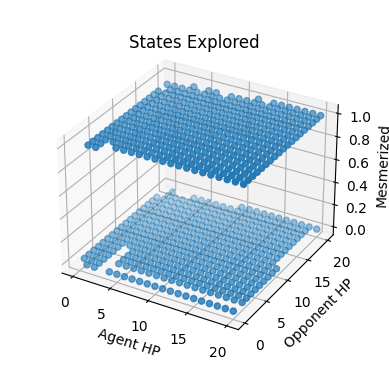

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

x,y,z = [],[],[]

for state in q_table_2.table:
  x.append(state.agent_hp)
  y.append(state.opponent_hp)
  z.append(state.opponent_mesmerized)

ax.scatter(x,y,z)
ax.set_xlabel('Agent HP')
ax.set_ylabel('Opponent HP')
ax.set_zlabel('Mesmerized')

ax.set_title('States Explored', y=0.95)
ax.set_box_aspect(aspect=None, zoom=0.85)

All of the holes in the grid correspond to unexplored states. In the course of the game, if the agent finds itself in an unexplored state, we could just have the agent randomly pick a move. However, we can do better using KNN. In this case, we can just take K=1 and have the agent pick the best action from the closest state. This should work well since the idea that the agent will act the same in similar states (i.e. similar agent_hp, opponent_hp, opponent_mesmerized) is likely a reasonable assumption.

In [9]:
#Setting up nearest neighbors
from sklearn.neighbors import NearestNeighbors
import numpy as np

data = []

#adding all of the states for KNN
#opponent mesmerized is changed from boolean 0 (False) and 1 (True) to
#0 (False) and 20 (True) so that it has a similar influence as the other state
#features since we are using Euclidean distance
for state in q_table_2.table:
  agent_hp, opponent_hp, opponent_mesmerized = state.get_fields()
  data.append([agent_hp, opponent_hp, opponent_mesmerized*20])


nbrs = NearestNeighbors(n_neighbors=1).fit(data)


In [14]:
#Setting up a simple game UI

from IPython.display import Audio, display
import panel as pn

#try switching between pn.extension() and pn.extension('perspective') here if
#the next cell is not executing as expected
pn.extension('perspective')

#initializing game variables
panels = []
agent_hp= MAX_HP
user_hp= MAX_HP
user_mesmerized=False


def get_agent_move():
  """
  - Returns the agent move in the current game state
  - If the state is unexplored, we use KNN to return the move
  - Uses Q table generated from mesmerize probability=0.8 but this can be
  changed easily
  """

  game_state = State(agent_hp, user_hp, user_mesmerized)

  #use KNN for unseen states
  if game_state not in q_table_2.table:
    query_state = [*game_state.get_fields()]
    #transform boolean field to same scale as other features
    query_state[2] *= 20

    _, index= nbrs.kneighbors([query_state])
    nbr_state = data[index[0][0]]
    #transform back to boolean
    nbr_state[2] /= 20
    nbr_state = State(*nbr_state)

    agent_move = q_table_2.table[nbr_state].index(max(q_table_2.table[nbr_state]))

  else:
    agent_move = q_table_2.table[game_state].index(max(q_table_2.table[game_state]))

  return AGENT_ACTIONS[agent_move]


def execute_agent_move():
  """
  - Gets the agents move and update the window
  """

  global user_hp, agent_hp, user_mesmerized

  agent_move = get_agent_move()

  if agent_move == "attack":
    user_mesmerized = False

    agent_damage = random.randint(1, MAX_DAMAGE)
    user_hp -= agent_damage
    user_hp = max(0, user_hp)

    panels.insert(0,
    pn.Row('Agent:', pn.pane.Markdown(f"Agent attacks for {agent_damage} hp", width=600,
                                      styles={'background-color': '#F6F6F6'})))

    #check if the agent has won after attacking
    if user_hp == 0:
      panels.insert(0,
        pn.Row('Game over:', pn.pane.Markdown("**The agent wins the game!**", width=600, styles={'background-color': 'red'})))

  elif agent_move == "heal":
    agent_heal = random.randint(1, MAX_HEAL)
    agent_hp += agent_heal
    agent_hp = min(MAX_HP, agent_hp)

    panels.insert(0,
    pn.Row('Agent:', pn.pane.Markdown(f"Agent heals {agent_heal} hp", width=600,
                                      styles={'background-color': '#F6F6F6'})))
  else:
    #mesmerize
    if random.random() < MESMERIZE_PROB:
      user_mesmerized = True
      panels.insert(0,
      pn.Row('Agent:', pn.pane.Markdown("Agent successfully mesmerizes the user", width=600,
                                        styles={'background-color': '#F6F6F6'})))
    else:
      panels.insert(0,
      pn.Row('Agent:', pn.pane.Markdown("Agent failed to mesmerize the user", width=600,
                                        styles={'background-color': '#F6F6F6'})))


def attack():
  """
  - Called when the user chooses to attack
  """

  global user_hp, agent_hp, user_mesmerized

  #execute user attack - check if mesmerized first
  if user_mesmerized:
    panels.insert(0,
      pn.Row('User:', pn.pane.Markdown(f"User is mesmerized and cannot move", width=600)))

    execute_agent_move()
  else:
    user_damage = random.randint(1, MAX_DAMAGE)
    agent_hp -= user_damage
    agent_hp = max(0, agent_hp)
    panels.insert(0,
        pn.Row('User:', pn.pane.Markdown(f"User attacks for {user_damage} hp", width=600)))

    #check if user wins
    if agent_hp == 0:
      panels.insert(0,
        pn.Row('Game over:', pn.pane.Markdown("**The user wins the game!**", width=600, styles={'background-color': 'green'})))

    else:
      execute_agent_move()

  panels.insert(0,
      pn.Row('Game stats:', pn.pane.Markdown(f"User hp: {user_hp}  Agent hp: {agent_hp}\
        User mesmerized: {user_mesmerized}", width=600)))

  return pn.Column(*panels)


def heal():
  """
  - Called when the user chooses to heal
  """
  global user_hp, agent_hp, user_mesmerized

  #execute user heal - check if mesmerized first
  if user_mesmerized:
    panels.insert(0,
      pn.Row('User:', pn.pane.Markdown(f"User is mesmerized and cannot move", width=600)))

    execute_agent_move()
  else:
    user_heal = random.randint(1, MAX_HEAL)
    user_hp += user_heal
    user_hp = min(MAX_HP, user_hp)
    panels.insert(0,
        pn.Row('User:', pn.pane.Markdown(f"User heals {user_heal} hp", width=600)))

    #no need to check if user has won when healing
    execute_agent_move()

  panels.insert(0,
      pn.Row('Game stats:', pn.pane.Markdown(f"User hp: {user_hp}  Agent hp: {agent_hp}\
        User mesmerized: {user_mesmerized}", width=600)))

  return pn.Column(*panels)


#callback functions to update the dashboard
def update_attack(event):
    dashboard[2] = pn.panel(attack(), height=300)

def update_heal(event):
    dashboard[2] = pn.panel(heal(), height=300)


#Setting up UI

instructions = pn.pane.Markdown("""
## A Wild RL Agent Appeared!

Choose to **Attack** or **Heal**:
""")

attack_button = pn.widgets.Button(name="Attack")
heal_button = pn.widgets.Button(name="Heal")

# Bind the callback functions to the button click events
attack_button.on_click(update_attack)
heal_button.on_click(update_heal)

dashboard = pn.Column(
    instructions,
    pn.Row(attack_button, heal_button),
    # Initial empty panels, will be updated later by button clicks
    pn.panel("", height=300),
)

Executing the following cell will start the game. To play multiple times, re-execute the pervious cell to reset the dashboard.

In [15]:
#If no output is produced or the UI is not responsive, try running the previous cell
#a few times and/or switching between pn.extension() and pn.extension('perspective').
#I'm not sure why this code can be finnicky.
#https://downloads.khinsider.com/game-soundtracks/album/pokemon-black-and-white-super-music-collection

url = "https://epsilon.vgmsite.com/soundtracks/pokemon-black-and-white-super\
-music-collection/fnsumwsmge/1-14.%20Battle%21%20%28Wild%20Pok%C3%A9mon%29.mp3"

display(Audio(url=url, autoplay=True))

dashboard.servable()

Column
    [0] Markdown(str)
    [1] Row
        [0] Button(name='Attack')
        [1] Button(name='Heal')
    [2] Markdown(str, height=300)

From playing the game it's clear that the agent has learned to play sensibly and uses its mesmerize ability in the same way that a human likely would. In particular, whenever the agent is low on hp, the agent mesemerizes the user and heal for several turns before attacking again. This gets really annoying to play against really fast...

##**Bells and Whistles to be Added**


1.   Instead of handcrafting the opponent's policy, we can also try using MCTS so the opponent is more adaptive and has some notion of thinking ahead: https://pypi.org/project/monte-carlo-tree-search/. (Does this use UCB1 and random rollouts?)
2.  New exploration strategy - thompson sampling (https://www.youtube.com/watch?v=Zgwfw3bzSmQ)

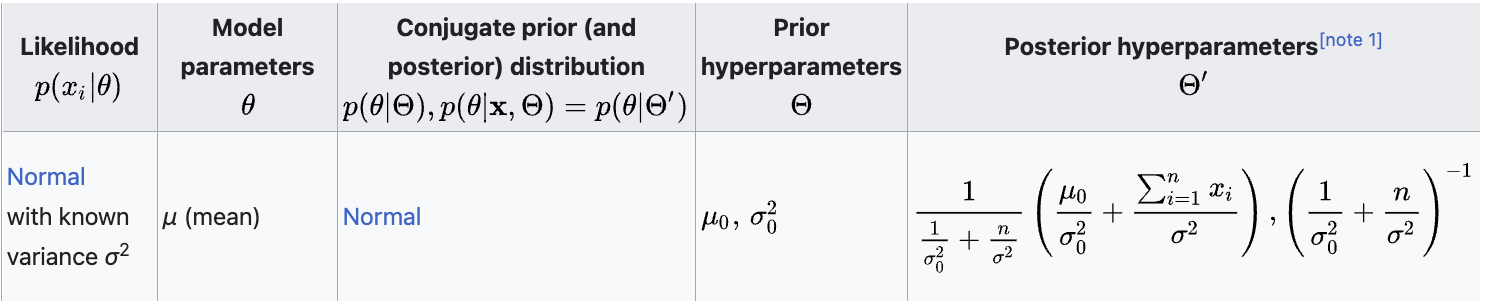